In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'vgt' # ticker symbol
model_name = 'Random Forest Classifier' # for display later
days_ahead = 1 # for predicting 1 day ahead
cv = 5 # number of cross validation folds

In [3]:
# Extract, Transform, Load, and Train Test Split
# aapl start date: 12/12/1980, trained 12/23/20
# tsla start date: 06/29/2010, trained 12/23/20
# vbiv start date: 09/04/2002, trained 12/23/20
# vgt start date: 01/26/2004, trained 12/23/20
# idex start date: 05/23/2007, trained 12/23/20
# iyw start date: 05/15/2000, trained 12/23/20
# 
start_dates = {'aapl':'12/12/1980'
               , 'idex': '05/23/2007'
               , 'iyw': '05/15/2000'
               , 'tsla': '06/29/2010'
               , 'vbiv': '09/04/2002'
               , 'vgt': '01/26/2004'
              }
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-10,339.869995,334.109985,334.890015,338.529999,796200.0,337.857880,-0.010869,0.017240,0.004421,0.012166,0.000426,-1
2020-12-11,338.000000,334.079987,336.489990,337.929993,423800.0,337.259064,-0.004279,0.011734,-0.001772,0.010568,-0.002171,1
2020-12-14,342.160004,339.170013,339.359985,339.380005,308600.0,338.706177,-0.000059,0.008816,0.004291,0.010795,-0.001811,1
2020-12-15,345.019989,341.209991,342.809998,345.019989,470100.0,344.334961,-0.006447,0.011166,0.016618,0.013568,0.000608,-1
2020-12-16,348.350006,344.459991,345.589996,347.529999,372900.0,346.839996,-0.005614,0.011293,0.007275,0.006709,0.006167,1
2020-12-17,350.489990,348.329987,349.260010,350.000000,487300.0,350.000000,-0.002119,0.006201,0.009111,0.006732,0.007105,-1
2020-12-18,350.809998,347.450012,350.769989,349.059998,378000.0,349.059998,0.004875,0.009670,-0.002686,0.007039,0.006922,1
2020-12-21,350.160004,342.559998,345.769989,349.989990,603600.0,349.989990,-0.012205,0.022186,0.002664,0.007226,0.006597,1
2020-12-22,355.070007,350.790009,352.160004,353.769989,525000.0,353.769989,-0.004572,0.012201,0.010800,0.005461,0.005433,-1


In [5]:
# # GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
# a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)

In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

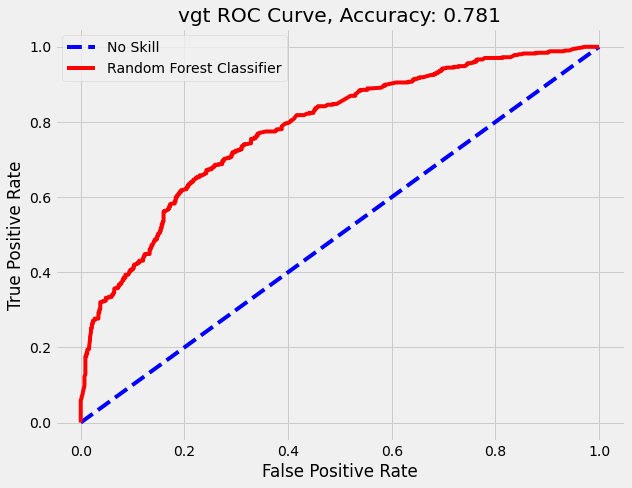

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

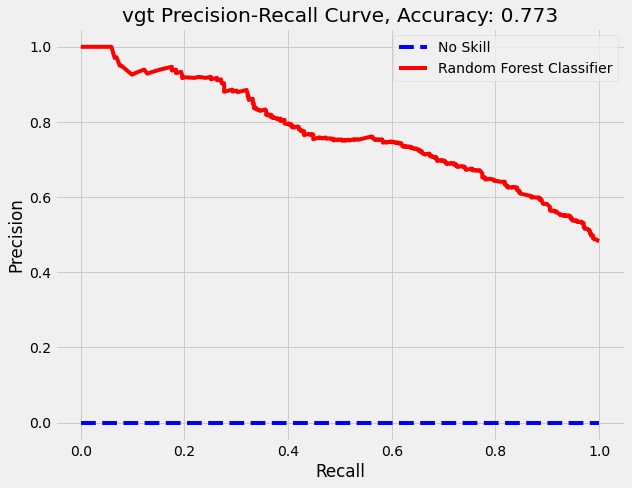

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

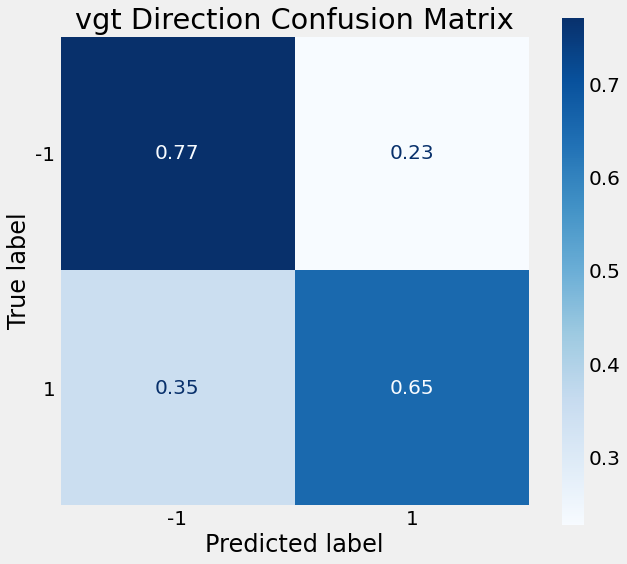

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.708306905370844'

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High             354.859985
Low              350.500000
Open             354.470001
Close            350.549988
Volume        388200.000000
Adj Close        350.549988
oc                 0.011059
hl                 0.012439
adj               -0.009102
5stdev_adj         0.008269
5sma_adj           0.002158
direction         -1.000000
Name: 2020-12-23 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-1]
last

oc            0.011059
hl            0.012439
5stdev_adj    0.008269
5sma_adj      0.002158
Name: 2020-12-23 00:00:00, dtype: float64

### Prediction...

In [13]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name}')
else:
    print(f'Sell or hold {stock_name}')

Buy vgt


In [14]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [15]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-17,350.489990,348.329987,349.260010,350.000000,487300.0,350.000000,-0.002119,0.006201,0.009111,0.006732,0.007105,-1,-1,0.002686
2020-12-18,350.809998,347.450012,350.769989,349.059998,378000.0,349.059998,0.004875,0.009670,-0.002686,0.007039,0.006922,1,1,0.002664
2020-12-21,350.160004,342.559998,345.769989,349.989990,603600.0,349.989990,-0.012205,0.022186,0.002664,0.007226,0.006597,1,-1,-0.010800
2020-12-22,355.070007,350.790009,352.160004,353.769989,525000.0,353.769989,-0.004572,0.012201,0.010800,0.005461,0.005433,-1,-1,0.009102
2020-12-23,354.859985,350.500000,354.470001,350.549988,388200.0,350.549988,0.011059,0.012439,-0.009102,0.008269,0.002158,-1,1,0.001187


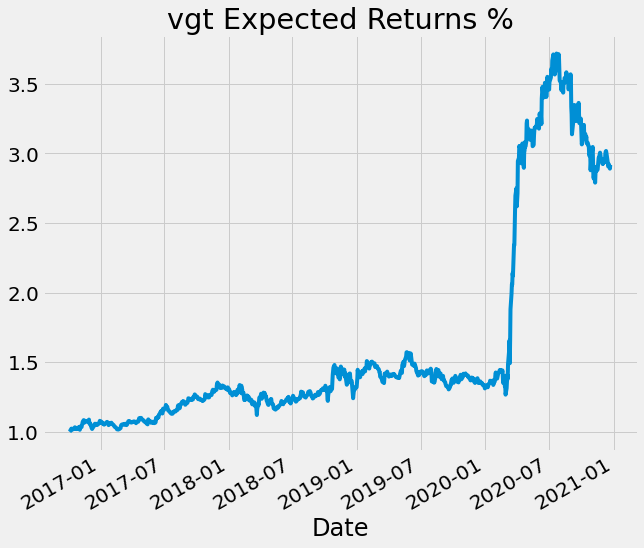

In [16]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [17]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

3.1606742561036887

In [18]:
# multiple times original investment, not bad but...

In [19]:
# If purchased in 2012 and left it until now
(stock_df['Close'][-1] - stock_df['Close'][-2522]) /stock_df['Close'][-2522]

4.674166311418603

In [20]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/